In [27]:
import time

import sys
sys.path.append('..')

import numpy as np
import pandas as pd

from torch.autograd import Variable
import torch
from torch import nn
from torch import autograd

In [2]:
from models.lap_srn import LapSRN
from models.unet import UNet

In [46]:
img_size = 100
def get_img(img_size):
    img = Variable(nn.init.constant(torch.Tensor(3,img_size,img_size).unsqueeze(0).cuda(), val=0.5 ), volatile=True)
    img = torch.cat(([img]))

    return img
img = get_img(img_size)
img


Variable containing:
( 0 , 0 ,.,.) = 
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
           ...             ⋱             ...          
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000

( 0 , 1 ,.,.) = 
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
           ...             ⋱             ...          
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000

( 0 , 2 ,.,.) = 
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000  0.5000
  0.5000  0.5000  0.5000  ...   0.5000  0.5000

In [21]:
lap_srn = LapSRN(depth=10, upsample=True).cuda().eval()
#unet = UNet(num_classes=3).cuda().eval()
#lap_deblur = LapSRN(depth=5, upsample=False).cuda().eval()

In [49]:
def time_model_single(model, img_size, n_times):
    times = []
    for i in range(n_times+2):
        img = get_img(img_size)
        torch.cuda.synchronize()
        torch.cuda.synchronize()
        start_event = torch.cuda.Event(enable_timing=True)
        end_event = torch.cuda.Event(enable_timing=True)
        
        start_event.record()

        model(img)
        
        end_event.record()
        end_event.synchronize()        
        
        #del up
        
        # Discard first measurement (outlier)
        if i != 0:
            times.append(start_event.elapsed_time(end_event)) # ms
    return np.array(times).mean()

def time_model(model, model_name, sizes=[16,32,64]):
    results = []
    for size in sizes:
        print(model_name, size)
        result = time_model_single(model, img_size=size, n_times=10)
        results.append((model_name, size, result))
    return results

In [50]:
#deblur_range = [16]
#upscale_range = [16]
#unet_times = time_model(unet, model_name='unet', sizes=deblur_range)
#lap_deblur_times = time_model(lap_deblur, model_name='lap_deblur', sizes=deblur_range)
time_model(lap_srn, model_name='lap_srn', sizes=[256])

lap_srn 256


[('lap_srn', 256, 77.11049235950817)]

In [45]:
time_model(lap_srn, model_name='lap_srn', sizes=[16,32, 64, 128, 256])

lap_srn 16
lap_srn 32
lap_srn 64
lap_srn 128
lap_srn 256


[('lap_srn',
  16,
  array([2.88463998, 2.37599993, 2.36339211, 2.36118388, 2.30604792,
         2.57337594, 3.636096  , 2.7339201 , 2.63168001, 2.5837121 ,
         2.48524809])),
 ('lap_srn',
  32,
  array([2.4289279 , 2.45779204, 2.70838404, 2.41356802, 2.38284802,
         2.56707191, 2.38905597, 2.36953592, 2.42374396, 2.49638391,
         2.38694406])),
 ('lap_srn',
  64,
  array([5.29407978, 5.38089609, 5.6104002 , 5.31148815, 5.38624001,
         5.62995195, 5.27564812, 5.351264  , 5.56646395, 5.2899518 ,
         5.37395191])),
 ('lap_srn',
  128,
  array([19.73119926, 19.70051193, 19.72348785, 22.31625557, 21.51971245,
         19.78976059, 19.71052742, 19.64649582, 19.69055939, 19.7363205 ,
         19.68643188])),
 ('lap_srn',
  256,
  array([76.64019012, 79.0192337 , 78.41359711, 76.37075043, 76.77101135,
         76.56764984, 76.63420868, 77.08175659, 76.67747498, 77.02524567,
         77.50870514]))]

In [14]:
max_unet = 2560
max_upscaling = 1024

deblur_range = [128, 256, 512, 1024, 1536, 2048]
upscale_range = [128, 256, 512, 1024]

In [15]:
time_model(lap_srn, 'l', [128, 256])

l 128
l 256


[('l', 128, array([2.6003  , 2.686338, 2.758724, 2.347797, 2.340097, 2.27034 ,
         2.27132 , 2.26727 , 3.459136, 2.678067, 2.605311])),
 ('l', 256, array([2.318265, 2.454977, 2.675267, 2.554116, 2.414063, 2.49421 ,
         2.37323 , 2.267871, 2.26033 , 2.498031, 2.355999]))]

In [35]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.read_csv('../../results/times.csv')

In [33]:
df

,model,img_size,num_outputs,time
0,unet,128,2,7.275322
1,unet,256,2,17.166054
2,unet,512,2,58.445059
3,unet,1024,2,238.271690
4,unet,1536,2,545.846730
5,unet,2048,2,980.117482
6,lap_deblur,128,1,1.520113
7,lap_deblur,128,2,2.942048
8,lap_deblur,256,1,5.417149
9,lap_deblur,256,2,10.324003


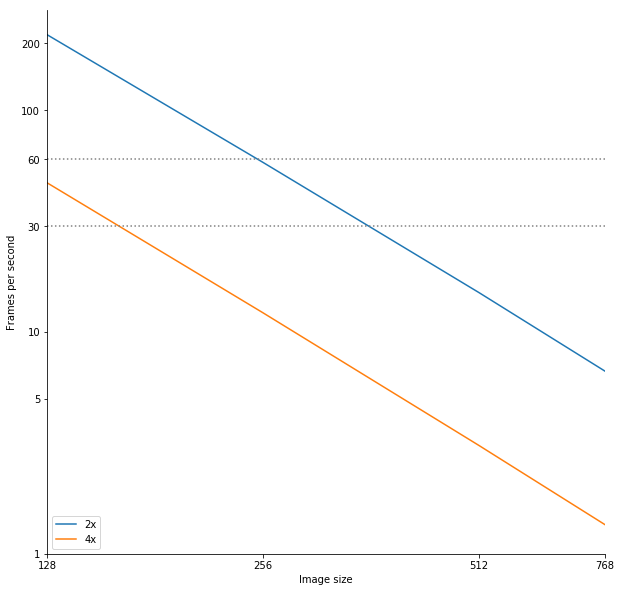

In [151]:
fig, ax = plt.subplots(figsize=(10,10))



dff = df.loc[(df['model'] == 'lap_srn') & (df['num_outputs'] == 1),:]
x = dff['img_size'].values
y = 1000/dff['time'].values
ax.loglog(x,y, label='2x')

dff = df.loc[(df['model'] == 'lap_srn') & (df['num_outputs'] == 2),:]
x = dff['img_size'].values
y = 1000/dff['time'].values

ax.loglog(x,y, label='4x')

ax.minorticks_off()
ax.set_xlim((128,768))
ax.set_xticks(x)

ax.set_yticks([200, 100, 60, 30, 10, 5, 1])
#ax.set_xticklabels([str(i) for i in x])

ax.set_xlabel('Image size')
ax.set_ylabel('Frames per second')

ax.legend(loc='lower left')

ax.axhline(30, c='gray', linestyle='dotted')
ax.axhline(60, c='gray', linestyle='dotted')


from matplotlib.ticker import ScalarFormatter
for axis in [ax.xaxis, ax.yaxis]:
    s = ScalarFormatter()
    #s.set_powerlimits((-3, 5))
    s.set_scientific(True)
    axis.set_major_formatter(ScalarFormatter())
sns.despine(fig, ax)

In [131]:
y

19     21.250502
21     81.911229
23    324.445440
25    739.378462
Name: time, dtype: float64

7475.1416015625